In [ ]:
!pip install utils
!pip install gym[box2d]
!pip install python3-utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 374 kB 14.2 MB/s 
     |████████████████████████████████| 1.8 MB 49.1 MB/s 
     |████████████████████████████████| 18.3 MB 140 kB/s 
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
    Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io

import numpy as np
from collections import deque, namedtuple

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

In [ ]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Mục mới

In [ ]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        # self.fc3 = nn.Linear(32, action_size)
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

In [ ]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
# GAMMA = 0.9
# GAMMA = 0.999
TAU = 1e-3              # for soft update of target parameters 0.001
LR = 5e-4               # learning rate 0.0005
#LR = 0.01
#LR = 0.001
#LR = 0.0005
UPDATE_EVERY = 4        # how often to update the network
# eps_decay=0.995
# eps_decay=0.99
#eps_decay=0.9


In [ ]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        ### Loss calculation (we used Mean squared error)
        # loss = F.mse_loss(q_expected, q_targets)
        loss = F.huber_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [ ]:
#decay = 0.99
def dqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.99):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores1 = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score1 = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score1 += reward
            if done:
                break 
        scores_window.append(score1)       # save most recent score
        scores1.append(score1)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score1: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score1: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score1: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores1

agent = Agent(state_size=8, action_size=4, seed=0)
scores1 = dqn()

Episode 100	Average Score1: -114.42
Episode 200	Average Score1: -37.80
Episode 300	Average Score1: -16.62
Episode 400	Average Score1: 97.79
Episode 500	Average Score1: 146.52
Episode 600	Average Score1: 145.91
Episode 700	Average Score1: 186.91
Episode 728	Average Score1: 201.34
Environment solved in 628 episodes!	Average Score1: 201.34


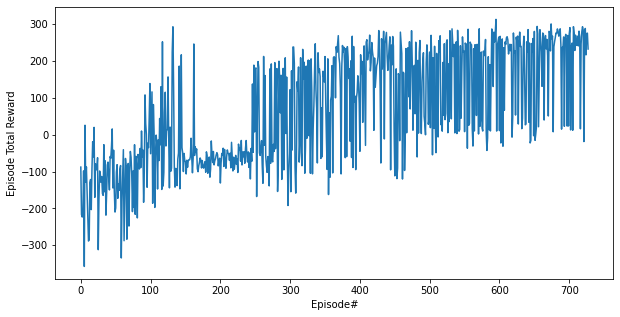

In [ ]:
# plot the scores
fig, ax = plt.subplots(figsize=(10,5))
# fig = plt.figure()
# ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores1)), scores1)
plt.ylabel('Episode Total Reward')
plt.xlabel('Episode#')
plt.show()

In [ ]:
# decay = 0.995
def dqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores2 = []     
    list_loss = []                   # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score2 = 0
        sum_loss = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            loss = agent.step(state, action, reward, next_state, done)
            state = next_state
            score2 += reward
            if loss is not None:
              sum_loss += float(loss.detach())
            if done:
                break 
        list_loss.append(sum_loss)
        scores_window.append(score2)       # save most recent score
        scores2.append(score2)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        # print('\rEpisode {}\tAverage Score2: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        # print('loss: ',sum_loss)

        if i_episode % 100 == 0:
            print('loss: ',sum_loss)

            print('\rEpisode {}\tAverage Score2: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score2: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores2 , list_loss

agent = Agent(state_size=8, action_size=4, seed=0)
scores2 , list_loss= dqn()

loss:  0
Episode 100	Average Score2: -143.46
loss:  0
Episode 200	Average Score2: -62.24
loss:  0
Episode 300	Average Score2: -22.83
loss:  0
Episode 400	Average Score2: 44.96
loss:  0
Episode 500	Average Score2: 124.51
loss:  0
Episode 600	Average Score2: 197.50

Environment solved in 504 episodes!	Average Score2: 201.22


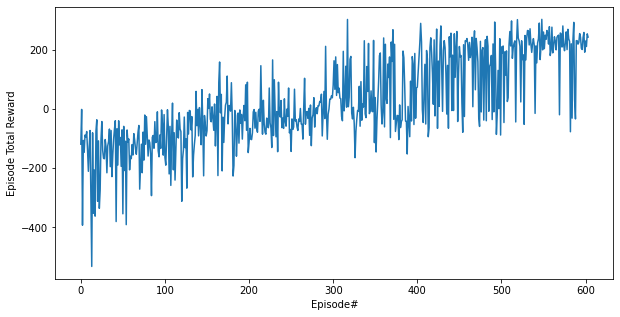

In [ ]:
# plot the scores
fig, ax = plt.subplots(figsize=(10,5))
# fig = plt.figure()
# ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores2)), scores2)
plt.ylabel('Episode Total Reward')
plt.xlabel('Episode#')
plt.show()

In [ ]:
# decay = 0.9
def dqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.9):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores3 = []     
    list_loss = []                   # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score3 = 0
        sum_loss = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            loss = agent.step(state, action, reward, next_state, done)
            state = next_state
            score3 += reward
            if loss is not None:
              sum_loss += float(loss.detach())
            if done:
                break 
        list_loss.append(sum_loss)
        scores_window.append(score3)       # save most recent score
        scores3.append(score3)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        # print('\rEpisode {}\tAverage Score3: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        # print('loss: ',sum_loss)

        if i_episode % 100 == 0:
            print('loss: ',sum_loss)

            print('\rEpisode {}\tAverage Score3: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score3: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores3 , list_loss

agent = Agent(state_size=8, action_size=4, seed=0)
scores3 , list_loss= dqn()

loss:  0
Episode 100	Average Score3: -64.46
loss:  0
Episode 200	Average Score3: -79.87
loss:  0
Episode 300	Average Score3: 49.89
loss:  0
Episode 400	Average Score3: 81.72
loss:  0
Episode 500	Average Score3: 80.69
loss:  0
Episode 600	Average Score3: 76.47
loss:  0
Episode 700	Average Score3: 146.42
loss:  0
Episode 800	Average Score3: 192.44

Environment solved in 737 episodes!	Average Score3: 200.12


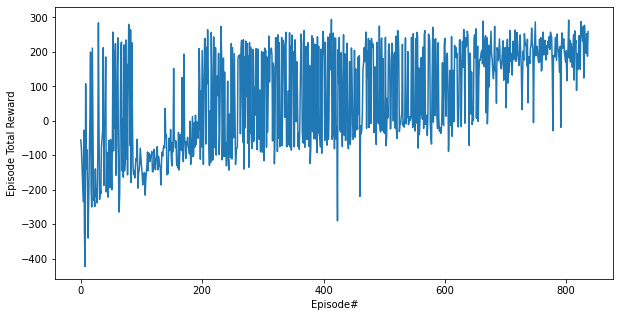

In [ ]:
# plot the scores
fig, ax = plt.subplots(figsize=(10,5))
# fig = plt.figure()
# ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores3)), scores3)
plt.ylabel('Episode Total Reward')
plt.xlabel('Episode#')
plt.show()

In [ ]:
def m_a(values, window=50):
    weight = np.repeat(1.0, window)/window
    smas = np.convolve(values,weight,'valid')
    return smas

In [ ]:
smas1 = m_a(scores1)
smas2 = m_a(scores2)
smas3 = m_a(scores3)

Text(0.5, 1.0, 'Deep Q learning (600 episodes training)')

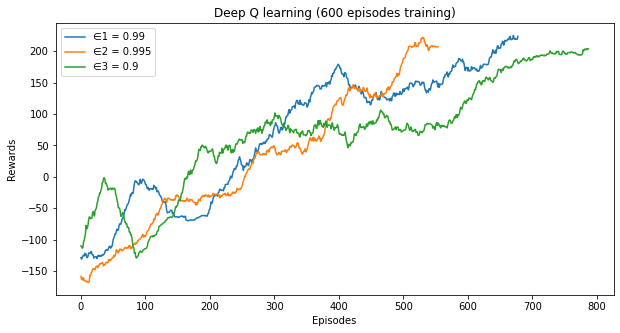

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(smas1)
ax.plot(smas2)
ax.plot(smas3)
plt.legend(['∈1 = 0.99','∈2 = 0.995','∈3 = 0.9'],loc = 'upper left')
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes')
ax.set_title('Deep Q learning (600 episodes training)')
#plt.savefig('Sarsa600epma', transparent=True)

In [ ]:
##γ1 = 0.999','γ2 = 0.99','γ3 = 0.9 
#fig, ax = plt.subplots(figsize=(10,5))
# ax.plot(smas1)
# ax.plot(smas2)
# ax.plot(smas3)
# plt.legend(['0.999','0.99','0.9'],loc = 'upper left')
# ax.set_ylabel('Rewards')
# ax.set_xlabel('Episodes')
# ax.set_title('Deep Q learning (600 episodes training)')
# #plt.savefig('Sarsa600epma', transparent=True)

In [ ]:
# #α1 = 0.005, α2 = 0.001, α3 = 0.005, α4 = 0.01
# fig, ax = plt.subplots(figsize=(10,5))
# ax.plot(smas1)
# ax.plot(smas2)
# ax.plot(smas3)
# plt.legend(['0.0005','0.001','0.005', '0.01'],loc = 'upper left')
# ax.set_ylabel('Rewards')
# ax.set_xlabel('Episodes')
# ax.set_title('Deep Q learning (600 episodes training)')
# #plt.savefig('Sarsa600epma', transparent=True)

In [ ]:
def show_video(env_name):
    mp4list = glob.glob('/content/sample_data/*.mp4')
    if len(mp4list) > 0:
        mp4 = '/content/sample_data/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
        
def show_video_of_model(agent, env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="/content/sample_data/{}.mp4".format(env_name))
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()
        
        action = agent.act(state)

        state, reward, done, _ = env.step(action)        
    env.close()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
agent = Agent(state_size=8, action_size=4, seed=0)
show_video_of_model(agent, 'LunarLander-v2')
# show_video('LunarLander-v2')

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym

In [ ]:
show_video('LunarLander-v2')

In [ ]:
# !pip freeze > 'requirements/requirements.txt'

In [ ]:
!python --version

Python 3.8.16
